In [1]:
import pandas as pd
import warnings
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import warnings
import itertools
warnings.filterwarnings("ignore")

In [3]:
# Loading the data and checking if it is correctly loaded
df = pd.read_excel('MER_T12_06.xlsx')
df.head(5)

,MSN,YYYYMM,Value,Description
0,CLEIEUS,197301,72.076,Coal Electric Power Sector CO2 Emissions
1,CLEIEUS,197302,64.442,Coal Electric Power Sector CO2 Emissions
2,CLEIEUS,197303,64.084,Coal Electric Power Sector CO2 Emissions
3,CLEIEUS,197304,60.842,Coal Electric Power Sector CO2 Emissions
4,CLEIEUS,197305,61.798,Coal Electric Power Sector CO2 Emissions


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MSN          5094 non-null   object
 1   YYYYMM       5094 non-null   int64 
 2   Value        5094 non-null   object
 3   Description  5094 non-null   object
dtypes: int64(1), object(3)
memory usage: 159.3+ KB


In [5]:
#Adding date column and checking the null rows
df['Date'] = df['YYYYMM'].apply(lambda x: pd.to_datetime(x, format = '%Y%m', errors ='coerce'))
df[df['Date'].isna()]['YYYYMM'].drop_duplicates().reset_index(drop = True).to_frame().T

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
YYYYMM,197313,197413,197513,197613,197713,197813,197913,198013,198113,198213,...,200613,200713,200813,200913,201013,201113,201213,201313,201413,201513


- We can see that all rows that have null 'Date' values are there because of rows with month 13. Although it is possible these rows were intentionally put in there for a purpose, it is not needed for our analysis so can safely remove them from our dataset

In [6]:
df.dropna(inplace = True)

In [7]:
#Transforming 'Value' column to float data type and checking the null values
df['Value_num'] = pd.to_numeric(df["Value"], errors = 'coerce')
df[df['Value_num'].isna()]

,MSN,YYYYMM,Value,Description,Date,Value_num
3396,GEEIEUS,197301,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-01-01,NaN
3397,GEEIEUS,197302,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-02-01,NaN
3398,GEEIEUS,197303,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-03-01,NaN
3399,GEEIEUS,197304,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-04-01,NaN
3400,GEEIEUS,197305,Not Available,Geothermal Energy Electric Power Sector CO2 Em...,1973-05-01,NaN
...,...,...,...,...,...,...
4164,NWEIEUS,198808,Not Available,Non-Biomass Waste Electric Power Sector CO2 Em...,1988-08-01,NaN
4165,NWEIEUS,198809,Not Available,Non-Biomass Waste Electric Power Sector CO2 Em...,1988-09-01,NaN
4166,NWEIEUS,198810,Not Available,Non-Biomass Waste Electric Power Sector CO2 Em...,1988-10-01,NaN
4167,NWEIEUS,198811,Not Available,Non-Biomass Waste Electric Power Sector CO2 Em...,1988-11-01,NaN


- It does seem the "null" or "Not Available" values are there simply because some fuel types were simply not utilzed back then. Therefore we will replace the null values with 0 instead of dropping them.

In [8]:
df['Value_num'] = df["Value_num"].fillna(0)

In [9]:
# Transforming and simplifying data for visualization and analysis
t = df['Description'].drop_duplicates().reset_index(drop = True)
t

0             Coal Electric Power Sector CO2 Emissions
1      Natural Gas Electric Power Sector CO2 Emissions
2    Distillate Fuel, Including Kerosene-Type Jet F...
3    Petroleum Coke Electric Power Sector CO2 Emiss...
4    Residual Fuel Oil Electric Power Sector CO2 Em...
5        Petroleum Electric Power Sector CO2 Emissions
6    Geothermal Energy Electric Power Sector CO2 Em...
7    Non-Biomass Waste Electric Power Sector CO2 Em...
8     Total Energy Electric Power Sector CO2 Emissions
Name: Description, dtype: object

In [10]:
#Creating 'Fuel Type' column with simplified description
dic ={}
dic[t[0]] = 'Coal'
dic[t[1]] = 'Natural Gas'
dic[t[2]] = 'Distillate Fuel'
dic[t[3]] = 'Petroleum Coke'
dic[t[4]] = 'Residual Fuel Oil'
dic[t[5]] = 'Petroleum'
dic[t[6]] = 'Geothermal Energy'
dic[t[7]] = 'Non Biomass Waste'
dic[t[8]] = 'Total'

df['Fuel Type'] = df['Description'].apply(lambda x: dic[x])

Text(0.5, 1.0, 'Monthly CO2 Emission by Fuel Type')

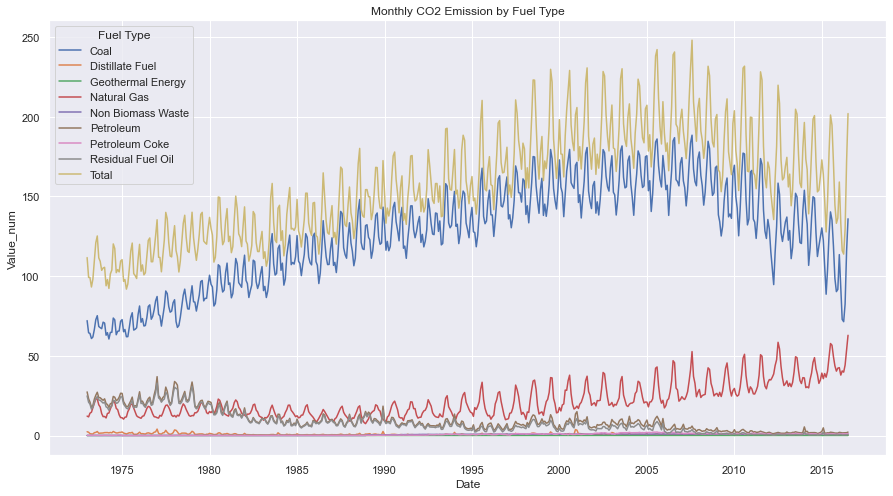

In [11]:
dfg = df.groupby(['Date', 'Fuel Type'])['Value_num'].sum().reset_index()
sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=dfg, x="Date", y="Value_num", hue="Fuel Type").set_title("Monthly CO2 Emission by Fuel Type")

**Observation**
-  Although we can see general trend from above plot, there does seem to be seasonality within 1 year period. To get better better visualization that better show overall trend, let's try to plot moving average instead.

Text(0.5, 1.0, '12 Month Moving Average of Monthly CO2 Emission by Fuel Type')

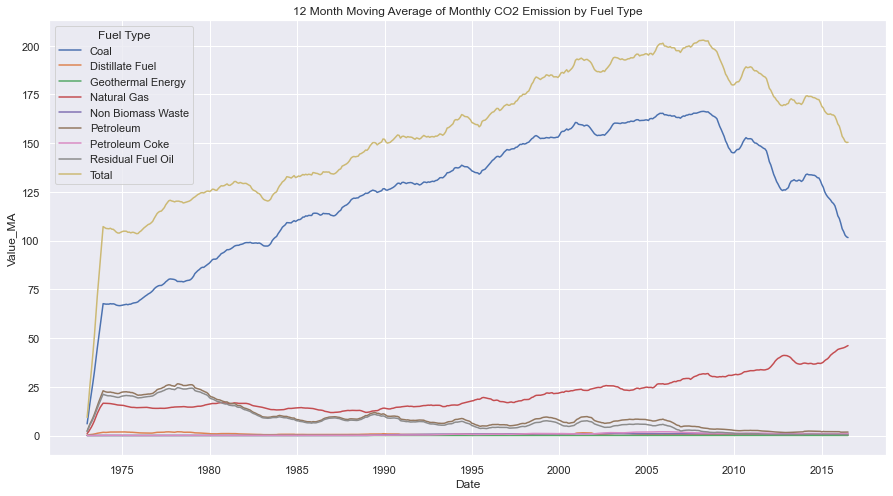

In [11]:
#Function to return 12 month moving Average
def MA_value(df,x):
    return df[(df['Date'] > x["Date"] - dt.timedelta(days = 365)) & (df['Date'] <= x["Date"]) & (df['Fuel Type'] == x['Fuel Type'])]['Value_num'].sum() / 12

dfg['Value_MA'] = dfg.apply(lambda x: MA_value(dfg,x), axis = 1)
sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=dfg, x="Date", y="Value_MA", hue="Fuel Type").set_title("12 Month Moving Average of Monthly CO2 Emission by Fuel Type")

**Observation**
- CO2 emissions from fuel sources other than Nautral gas and coal have become rather irrelavent since the mid 2000's. For the convenience of our analysis, and since our interest is in the future, I will lump 'Distillate Fuel', 'Petroleum', "Petroleum coke" and "Residual Fuel Oil"  together as "Crude Oil" and "Geothermal Energy" as "Renewable Energy" (this is more for future merge with other data sets)

- While CO2 emission from natrual gas has been steadily increasing, the overall CO2 emission rate from all energy sources is decreasing since the mid 2000's. This is because CO2 emission from its major contributor, coal, has been dropping more than the increased emission from natural gas. It does seem from the chart that natural gas is replacing coal as US energy source and it is contributing to the overall decrease of CO2 emission.

- In other words, We can form a hypothesis as such : "Replacing energy produced by coal to energy produced by natural gas will result lower total CO2 emission"

- However, we will need to gather the following data before we confirm above hypothesis
    - Overall energy production total trend
    - Energy production from other relatively CO2 free energy sources (nuclear, renewable energy, etc.) 
    - CO2 emission per energy produced by natural gas and coal

Text(0.5, 1.0, '12 Month Moving Average of Monthly CO2 Emission by Fuel Type')

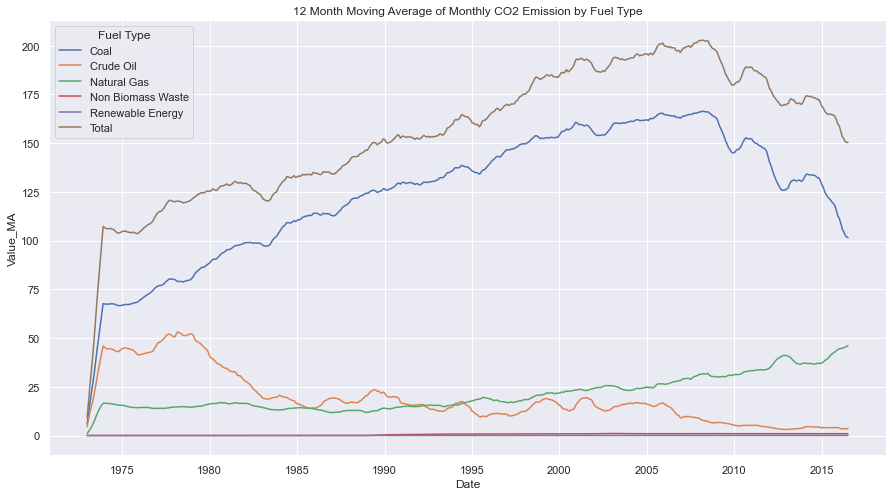

In [12]:
#Final Transformation/simplification of our original data set and its visualization

df_final = dfg[~dfg['Fuel Type'].isin(['Distillate Fuel','Petroleum','Petroleum Coke','Residual Fuel Oil'])]
df_final['Fuel Type'] = df_final['Fuel Type'].replace('Geothermal Energy',"Renewable Energy")


df_temp = dfg[dfg['Fuel Type'].isin(['Distillate Fuel','Petroleum','Petroleum Coke','Residual Fuel Oil'])]
df_temp = df_temp.groupby(['Date']).sum().reset_index()
df_temp["Fuel Type"] = 'Crude Oil'

df_final = df_final.append(df_temp)

df_final = df_final.groupby(['Date', 'Fuel Type']).sum().reset_index()
df_final.sort_values(['Date', 'Fuel Type'])

sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=df_final, x="Date", y="Value_MA", hue="Fuel Type").set_title("12 Month Moving Average of Monthly CO2 Emission by Fuel Type")

#df_final is the date set we will use when merging with other data sets

In [13]:
# Loading new data for total energy production by energy source
# Data source : https://www.eia.gov/totalenergy/data/monthly/
# Table Name : 1.2 Primary energy production by source
# The unit for this table is : Quadrillion Btu

df2 = pd.read_excel('resources\\table_energy_production.xlsx')
# Selecting the relavant columns. 
print("Original columns =", df2.columns)
df2['Natural Gas'] = df2['Natural Gas Plant Liquids Production'] + df2['Natural Gas (Dry) Production']
df2 = df2[['Month', 'Coal Production', 'Natural Gas','Total Renewable Energy Production', 'Nuclear Electric Power Production','Crude Oil Production','Total Primary Energy Production']]
print("Selected columns =", df2.columns)
#Renaming Columns for simplicity for possible merge with original table
df2.columns = ['Date', 'Coal', 'Natural Gas', 'Renewable Energy','Nuclear Energy', 'Crude Oil', 'Total']

#Transforming shape to same as our original table
df2 = pd.melt(df2, id_vars = ['Date'], value_vars = ['Coal', 'Natural Gas', 'Renewable Energy','Nuclear Energy', 'Crude Oil','Total'], var_name='Fuel Type', value_name='Energy_Value')
df2 = df2.sort_values(['Date','Fuel Type']).reset_index(drop = True)
df2.head(5)

Original columns = Index(['Month', 'Coal Production', 'Natural Gas (Dry) Production',
       'Crude Oil Production', 'Natural Gas Plant Liquids Production',
       'Total Fossil Fuels Production', 'Nuclear Electric Power Production',
       'Hydroelectric Power Production', 'Geothermal Energy Production',
       'Solar Energy Production', 'Wind Energy Production',
       'Biomass Energy Production', 'Total Renewable Energy Production',
       'Total Primary Energy Production'],
      dtype='object')
Selected columns = Index(['Month', 'Coal Production', 'Natural Gas',
       'Total Renewable Energy Production',
       'Nuclear Electric Power Production', 'Crude Oil Production',
       'Total Primary Energy Production'],
      dtype='object')


,Date,Fuel Type,Energy_Value
0,1973-01-01,Coal,1.166486
1,1973-01-01,Crude Oil,1.649833
2,1973-01-01,Natural Gas,2.116313
3,1973-01-01,Nuclear Energy,0.068103
4,1973-01-01,Renewable Energy,0.403981


In [14]:
#Merging the new data with our original data set
dfm= df_final.merge(df2, how = 'outer', on = ['Date', 'Fuel Type'])
dfm.fillna(0, inplace = True)

In [15]:
# Calculating CO2 emission / Energy produced into new columns (for both monthly and 12 month moving average)
dfm['CO2_Metric Ton per Billion Btu'] =  dfm['Value_num'] / dfm['Energy_Value']
dfm.fillna(0, inplace = True)

def MA_energy(df,x):
    return df[(df['Date'] > x["Date"] - dt.timedelta(days = 365)) & (df['Date'] <= x["Date"]) & (df['Fuel Type'] == x['Fuel Type'])]['Energy_Value'].sum() / 12

dfm['Energy_Value_MA'] = dfm.apply(lambda x: MA_energy(dfm,x), axis = 1)
dfm['CO2_Metric Ton per Billion Btu_MA'] =  dfm['Value_MA'] / dfm['Energy_Value_MA']

**Observation**
- Here I have calculated CO2 emission per energy produced by deviding CO2 emmission by energy produced (The unit is million metric ton / quadrillion Btu = metric ton / billion Btu)

- By definition, this variable should be close to a constant, let's plot this to see if it does behave as such

<AxesSubplot:title={'center':'CO2 Emission Per Energy Produced'}, xlabel='Date', ylabel='CO2_Metric Ton per Billion Btu'>

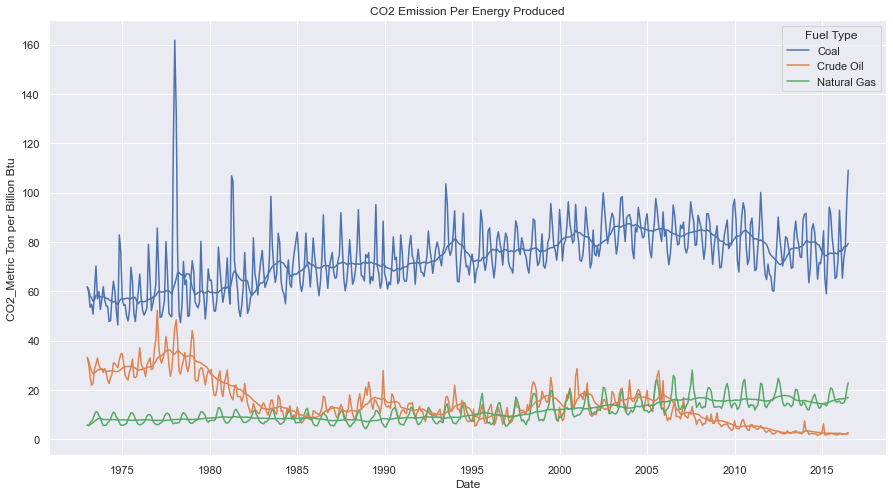

In [16]:
df_temp = dfm[dfm["CO2_Metric Ton per Billion Btu"] >0]
df_temp = df_temp[df_temp['Fuel Type'].isin(['Coal','Natural Gas','Crude Oil'])]
sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=df_temp, x="Date", y="CO2_Metric Ton per Billion Btu", hue="Fuel Type").set_title("CO2 Emission Per Energy Produced")
sns.lineplot(data=df_temp, x="Date", y="CO2_Metric Ton per Billion Btu_MA", hue="Fuel Type" , legend = False)

**Observation**
- Although there are a few outliers, "CO2 emission per energy produced" does indeed behave close to a constant over time.
- Natural gas seem to be 4 ~ 6 times more 'CO2' efficient than coal and when it comes to energy production. This supports my initial hypothesis.
- "CO2" efficiency of Crude oil has been decreasing dramatically over time as well. I suspect there were a couple of changes in how energy is produced using crude oil 
(once in 1980's and another time mid 2000's)

Text(0.5, 1.0, 'Energy Produced by Each Energy Source')

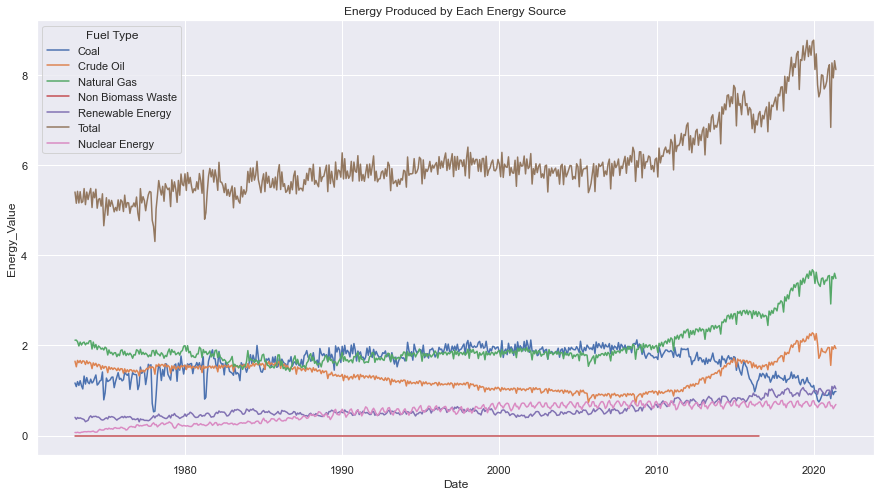

In [120]:
#Now let's see if energy from coal was replaced by energy from natural gas
df_temp = dfm[['Date', 'Fuel Type', 'Energy_Value']]

sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(data=df_temp, x="Date", y="Energy_Value", hue="Fuel Type").set_title("Energy Produced by Each Energy Source")

**Observation**
- Total energy produced in US has been rising dramatically since 2010, however total CO2 emission rate has been decreasing in the same time period.
This is because much of energy production from coal has been replaced by energy produced by natural gas and crude oil which are much more 'CO2' efficient compared to coal energy
- Energy production from nuclear and renewable energy has been steadily rising as well. However, their contribution to overall energy production is yet very low and its increasing rate is nowhere enough to cover increasing Energy need. 
    
**Thus, we can conclude that replacing energy source from coal to natural gas and crude oil was indeed the major factor behind decrease of CO2 emission from energy production despite increased overall energy production since 2010**